In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
from sklearn import manifold
import torch
import gym
import utils
from SAC import SAC
from DistSAC import DistSAC
import dm_control2gym
from mpl_toolkits import mplot3d
%matplotlib inline  

In [2]:
env = dm_control2gym.make(domain_name='point_mass', task_name='easy', visualize_reward=True, task_kwargs={'random': 1})
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
min_action = float(env.action_space.low[0])

In [3]:
goals = torch.FloatTensor([0.3, 0.3, 0, 0]).to(device).unsqueeze(0)

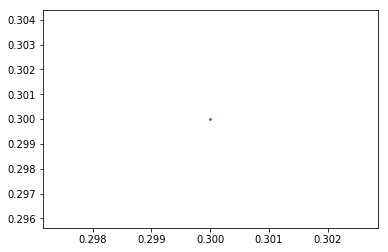

In [4]:
plt.scatter(goals[:, 0].cpu().numpy(), goals[:, 1].cpu().numpy(), s=3)

In [5]:
def make_grid(step=0.01):
    y, x = np.mgrid[slice(-0.3, 0.3, 0.01), slice(-0.3, 0.3, 0.01)]
    qpos = np.stack([x, y])
    qpos = qpos.reshape(2, -1).transpose(1, 0)
    qvel = np.random.uniform(0, 0, (qpos.shape[0], 2))
    state = torch.FloatTensor(np.hstack((qpos, qvel))).to(device)
    return state, x, y

In [6]:
def plot_dist(policy, dist):
    state, x, y = make_grid()
    
    ds = []
    for i in range(state.size(0)):
        with torch.no_grad():
            d, _ = dist.get_distance(state[i], goals)
        ds.append(d)
    ds = np.array(ds)
    ds = ds.reshape(x.shape[0], y.shape[0])
    
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['font.size'] = 10

    
    ax = plt.axes(projection='3d')
    ax.view_init(60, 35)
    ax.plot_surface(x, y, ds, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    #plt.axes(projection='3d')
    #plt.pcolormesh(x, y, -pot)
    #plt.contour3D(x, y, -pot, 50)
    plt.title('dist')
    #plt.colorbar()
    plt.show()

In [7]:
def plot_vf(policy):
    state, x, y = make_grid()
    
    with torch.no_grad():
        vf = policy.get_value(state, num_samples=10).cpu()
    vf = vf.view(x.shape[0], y.shape[0]).numpy()
    
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['font.size'] = 10

    ax = plt.axes(projection='3d')
    ax.view_init(60, 35)
    ax.plot_surface(x, y, vf, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    #plt.axes(projection='3d')

    #plt.colorbar()
    plt.title('value function')
    plt.show()

In [8]:
def load_model(model_id, model_version):
    policy = SAC(device, state_dim, action_dim, max_action, initial_temperature=0.01)
    model_dir = os.path.join('.', model_id)
    policy.load(model_dir, model_version)
    dist = DistSAC(device, state_dim, action_dim, max_action, initial_temperature=0.01, num_candidates=1)
    dist.load(model_dir, model_version)
    return policy, dist

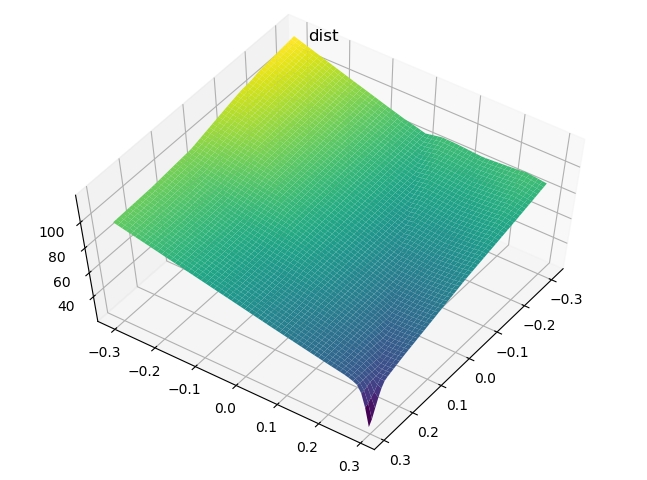

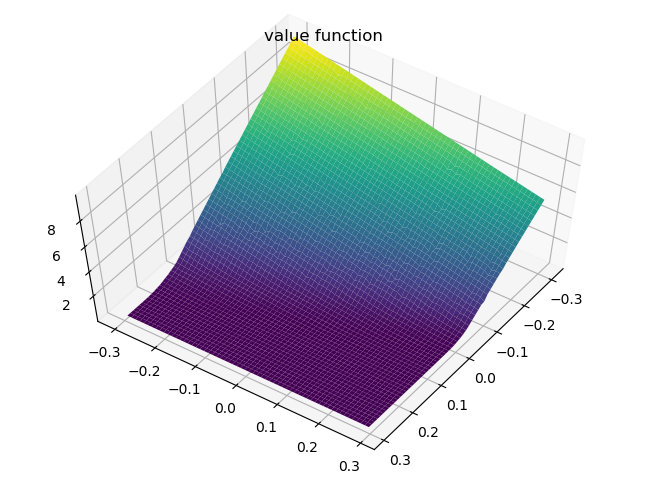

In [18]:
VERSION = 40000
policy, dist_policy = load_model('save', VERSION)
plot_dist(policy, dist_policy)
plot_vf(policy)

In [23]:
VERSION = 500000


gail_l2, _ = load_model('algo_sac_gail_l2pot_1_potcoef_0_seed_1', VERSION)
#gail_pot, _ = load_model('algo_sac_gail_pretraineddist_potcoef_0.01_seed_1', VERSION)

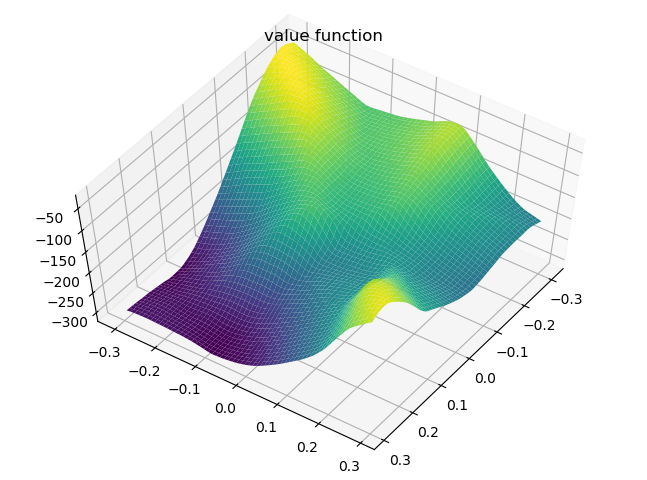

In [24]:
plot_vf(gail_l2)

In [15]:
VERSION = 100000


gail_l2, _ = load_model('algo_sac_latest_seed_1', VERSION)
#gail_pot, _ = load_model('algo_sac_gail_pretraineddist_potcoef_0.01_seed_1', VERSION)

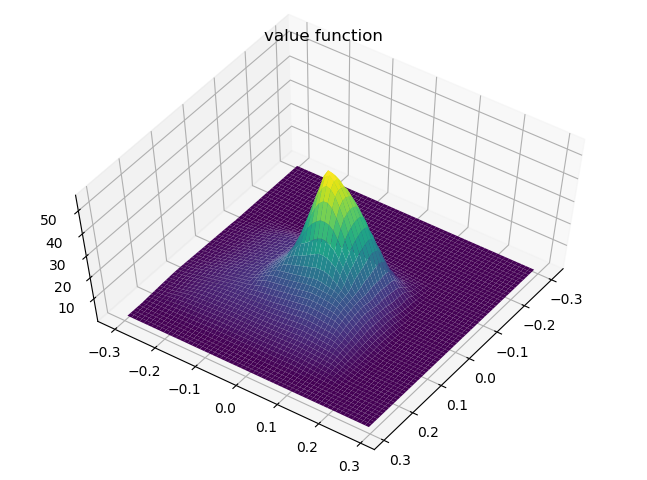

In [16]:
plot_vf(gail_l2)

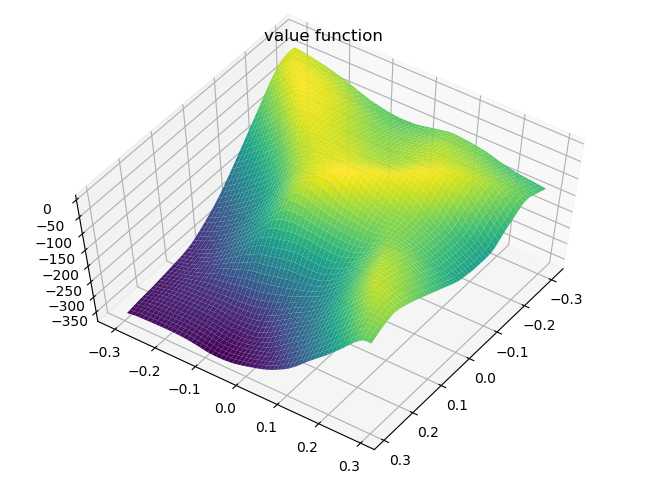

In [9]:
plot_vf(gail_pot)

In [104]:
def run_policy(env, policy):
    states, actions = [], []
    state = env.reset()
    done = False
    sum_reward = 0
    while not done:
        with torch.no_grad():
            action = policy.select_action(state)
        states.append(state)
        actions.append(action)
        state, reward, done, _ = env.step(action)
        sum_reward += reward
    return np.array(states), np.array(actions), sum_reward

In [120]:
states, actions, reward = run_policy(env, gail_pot)
with torch.no_grad():
    pot, idx = gail_pot.get_potential(dist, torch.FloatTensor(states).to(device))
c1 = gail_pot.target_states[idx[:, 0]].cpu().numpy()
pot = pot[:, 0].cpu().numpy()

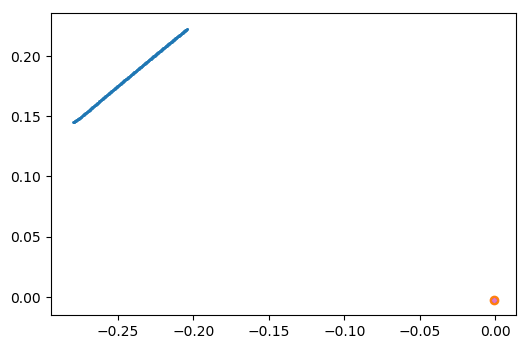

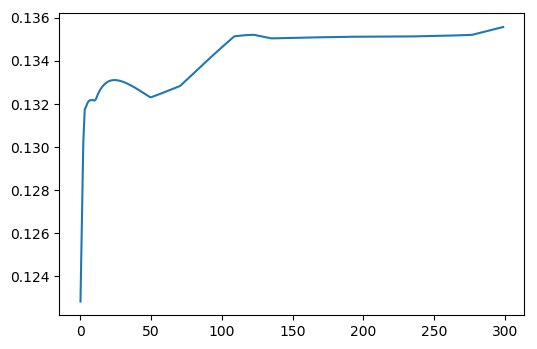

In [128]:
n = 300
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 100
plt.scatter(states[:n, 0], states[:n, 1], s=1)
plt.scatter(c1[n-1:n, 0], c1[n-1:n, 1])
target_states = gail_pot.target_states.view(5, -1, 4).cpu().numpy()
for i in range(target_states.shape[0]):
    plt.scatter(target_states[i, :, 0], target_states[i, :, 1], s=3)
plt.show()    
plt.clf()
plt.plot(pot[:n])

In [68]:
env.reset()

array([0.21830571, 0.22887186, 0.        , 0.        ])

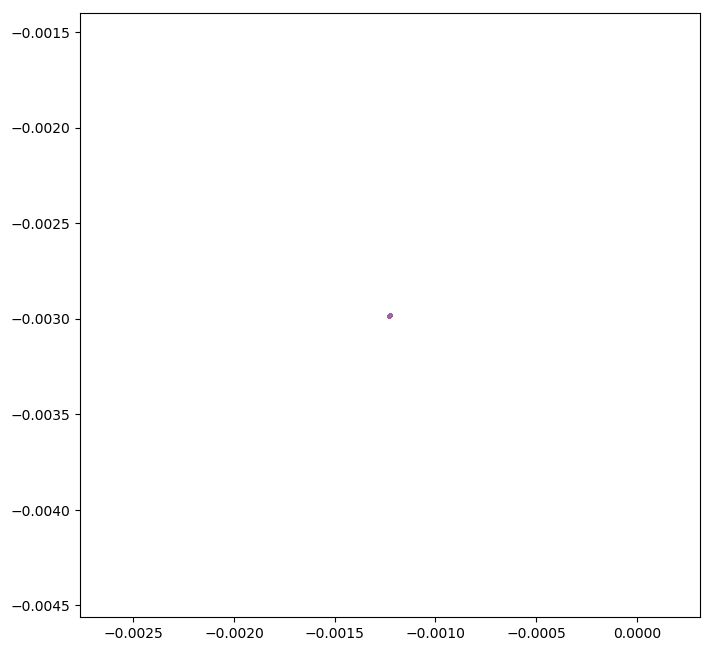

In [71]:
target_states = gail_pot.target_states.view(5, -1, 4).cpu().numpy()
for i in range(target_states.shape[0]):
    plt.scatter(target_states[i, :, 0], target_states[i, :, 1], s=3)

In [37]:
VERSION = 20000
gail_pot1, dist1 = load_model('algo_sac_pottozero_gail_l2pot_0_justpotreward_0_seed_1', VERSION)
gail_pot2, dist2 = load_model('algo_sac_pottozero_gail_l2pot_1_justpotreward_0_seed_1', VERSION)

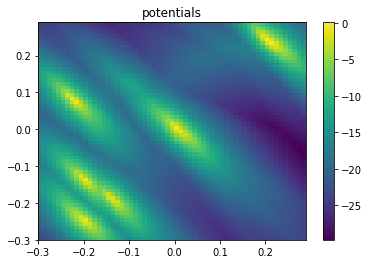

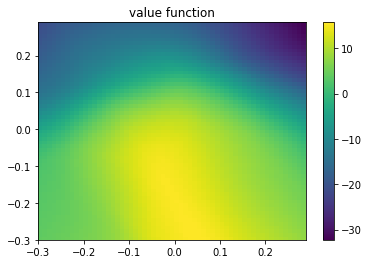

In [38]:
plot_pot(gail_pot1, dist1)
plot_vf(gail_pot1)

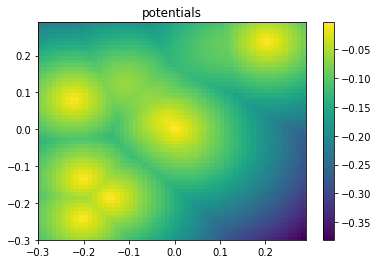

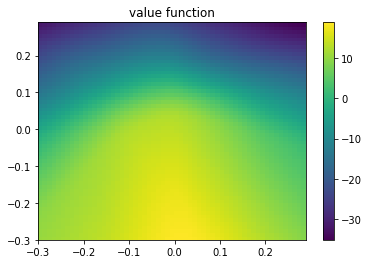

In [39]:
plot_pot(gail_pot2, dist2, use_l2=True)
plot_vf(gail_pot2)

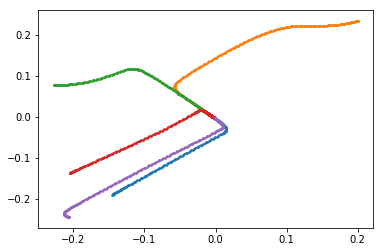

In [40]:
target_states = gail_pot1.target_states.view(5, -1, 4).cpu().numpy()
for i in range(target_states.shape[0]):
    plt.scatter(target_states[i, :, 0], target_states[i, :, 1], s=3)